# Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 15.08.2023

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../utils")

In [ ]:
import gc
import os
import warnings
from datetime import datetime

import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable

#from nichecompass.benchmarking import compute_benchmarking_metrics
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

import scanpy as sc

from ablation_utils import *
from analysis_utils import plot_category_in_latent_and_physical_space

In [ ]:
# tmp
def scale_metric(metric,
                 reverse=True):
    scaled_metric = math.atan(metric) / (math.pi / 2)
    if reverse:
        scaled_metric = 1 - scaled_metric
    return scaled_metric

import math

In [ ]:
# tmp
def get_loss_weights(row):  
    return f"lambda_edge_recon_{row['lambda_edge_recon_']}_+_lambda_gene_expr_recon_{row['lambda_gene_expr_recon_']}"

In [ ]:
# tmp
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import tickcross
from plottable.plots import bar

from nichecompass.utils import create_new_color_dict


def plot_metrics_table(df,
                       ablation_col,
                       ablation_col_width,
                       group_col,
                       metric_cols,
                       metric_col_weights,
                       metric_col_titles=None,
                       metric_col_width=1.5,
                       plot_width=15,
                       plot_height=10,
                       group_label_dict={"starmap_plus_mouse_cns": "STARmap PLUS Mouse CNS",
                                         "xenium_human_breast_cancer": "Xenium Human Breast Cancer",
                                         "vizgen_merfish_human_ovarian_cancer": "Vizgen MERFISH Human Ovarian Cancer"},
                       show=True,
                       save_dir=None,
                       save_name="ablation_results.svg"):
    """"""
    if metric_col_titles is None:
        metric_col_titles = [col.upper().replace("_", " ").replace(" ", "\n") for col in metric_cols]
    
    groups = df[group_col].unique().tolist()
    df = df.pivot(index=[ablation_col], columns=[group_col, "score_type"], values="score")
    df.reset_index(inplace=True)
    df.columns = ['_'.join(col).strip("_") for col in df.columns.values]
    if len(groups) > 1:
        sorted_metrics_col_list = []
        for i, group in enumerate(groups): 
            sorted_group_metrics_col_list = sorted([col for col in list(df.columns) if group in col],
                                           key=lambda x: [metric_cols.index(metric) for metric in metric_cols if x.endswith(metric)])
            df[f"Overall Score ({i})"] = np.average(df[sorted_group_metrics_col_list],
                                                    weights=metric_col_weights,
                                                    axis=1)
            sorted_metrics_col_list.extend(sorted_group_metrics_col_list)
        df = df[[ablation_col] + sorted_metrics_col_list + [f"Overall Score ({i})" for i in range(len(groups))]]
        df["Overall Score (All)"] = np.average(df[sorted_metrics_col_list],
                                               weights=metric_col_weights * len(groups),
                                               axis=1)
        df.sort_values(by=["Overall Score (All)"], inplace=True, ascending=False)
        
    else:
        sorted_metrics_col_list = sorted([col for col in list(df.columns) if any(col.endswith(metric) for metric in metric_cols)],
                                  key=lambda x: [metric_cols.index(metric) for metric in metric_cols if x.endswith(metric)])
        df = df[[ablation_col] + sorted_metrics_col_list]
        df["Overall Score"] = np.average(df[sorted_metrics_col_list],
                                         weights=metric_col_weights,
                                         axis=1)
        df.sort_values(by=["Overall Score"], inplace=True, ascending=False)
    
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

    column_definitions = [
        ColumnDefinition(name=ablation_col,
                         title=ablation_col.replace("_", " ").title(),
                         width=ablation_col_width,
                         textprops={"ha": "left", "weight": "bold"})]

    aggregate_cols = [col for col in list(df.columns) if "Overall" in col]

    for i, group in enumerate(groups):
        if len(groups) > 1:
            group_number_string = f"({i})"
        else:
            group_number_string = ""
        # Circles for the metric columns
        column_definitions += [
            ColumnDefinition(
                name=f"{group}_{col}",
                title=metric_col_titles[j],
                width=metric_col_width,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.25}},
                cmap=cmap_fn(df[f"{group}_{col}"]),
                group=f"Dataset Metrics \n {group_label_dict[group]} {group_number_string}",
                border="left" if j == 0 else None,
                formatter="{:.3f}")
            for j, col in enumerate(metric_cols)]

        # Circles for the aggregate columns
        column_definitions += [
            ColumnDefinition(
                name=col,
                title=col.replace(" ", "\n"),
                width=metric_col_width,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.25}},
                cmap=cmap_fn(df[col]),
                group="Aggregates",
                border="left" if j == 0 else None,
                formatter="{:.3f}")
            for j, col in enumerate(aggregate_cols)]

    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(plot_width, plot_height))
        tab = Table(
            df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k"},
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col=ablation_col,
        ).autoset_fontcolors(colnames=df.columns)
    if show:
        plt.show()
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)        
        fig.savefig(os.path.join(save_dir, save_name), facecolor=ax.get_facecolor(), dpi=300)
    return tab

In [ ]:
# tmp
def visualize_niches(artifact_folder_path,
                     dataset,
                     task,
                     timestamps,
                     sample_key,
                     latent_key,
                     latent_leiden_resolution=0.2,
                     latent_cluster_key="nichecompass_latent_clusters",
                     spot_size=0.03,
                     groups=None,
                     save_fig=False,
                     save_folder_path="",
                     file_name="",
                     file_format="png"):
    for timestamp in timestamps:
        adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/{task}/{timestamp}/{dataset}_{task}.h5ad")
        samples = adata.obs[sample_key].unique().tolist()

        # Compute latent Leiden clustering
        sc.tl.leiden(adata=adata,
                     resolution=latent_leiden_resolution,
                     key_added=latent_cluster_key,
                     neighbors_key=latent_key)
        
        latent_cluster_colors = create_new_color_dict(
            adata=adata,
            cat_key=latent_cluster_key)
        
        print(latent_cluster_colors)
        print(adata.obs[latent_cluster_key])

        fig = plt.figure(figsize=(12, 14))
        title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                               "in Latent and Physical Space",
                             y=0.96,
                             x=0.55,
                             fontsize=20)
        spec1 = gridspec.GridSpec(ncols=1,
                                  nrows=2,
                                  width_ratios=[1],
                                  height_ratios=[3, 2])
        spec2 = gridspec.GridSpec(ncols=len(samples),
                                  nrows=2,
                                  width_ratios=[1] * len(samples),
                                  height_ratios=[3, 2])
        axs = []
        axs.append(fig.add_subplot(spec1[0]))
        sc.pl.umap(adata=adata,
                   color=[latent_cluster_key],
                   groups=groups,
                   palette=latent_cluster_colors,
                   title=f"Latent Clusters in Latent Space",
                   ax=axs[0],
                   show=False)
        for idx, sample in enumerate(samples):
            axs.append(fig.add_subplot(spec2[len(samples) + idx]))
            sc.pl.spatial(adata=adata[adata.obs[sample_key] == sample],
                          color=[latent_cluster_key],
                          groups=groups,
                          palette=latent_cluster_colors,
                          spot_size=spot_size,
                          title=f"Latent Clusters in Physical Space \n"
                                f"(Sample: {sample})",
                          legend_loc=None,
                          ax=axs[idx+1],
                          show=False)

        # Create and position shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        lgd = fig.legend(handles,
                         labels,
                         loc="center left",
                         bbox_to_anchor=(0.98, 0.5))
        axs[0].get_legend().remove()

        # Adjust, save and display plot
        plt.subplots_adjust(wspace=0.2, hspace=0.25)
        if save_fig:
            fig.savefig(f"{save_folder_path}/{file_name}_{timestamp}.{file_format}",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
        plt.show()
        gc.collect()

In [ ]:
# tmp
def get_loss_weights(row):  
    return f"lambda_edge_recon_{row['lambda_edge_recon_']}_+_lambda_gene_expr_recon_{row['lambda_gene_expr_recon_']}"

In [ ]:
# tmp
def get_loss_weights_combination(row):  
    return f"""{'Neither' if (row['lambda_edge_recon_'] == 0.0) & (row['lambda_gene_expr_recon_'] == 0.0) else (
                'Only Spatial Gene Expr Recon' if (row['lambda_edge_recon_'] == 0.0) & (row['lambda_gene_expr_recon_'] != 0.0) else (
                'Only Edge Recon' if (row['lambda_edge_recon_'] != 0.0) & (row['lambda_gene_expr_recon_'] == 0.0) else 'Spatial Gene Expr Recon & Edge Recon'))}"""

### 1.2 Define Parameters

In [39]:
latent_key = "nichecompass_latent"
spatial_key = "spatial"
latent_knng_key = "nichecompass_latent_knng"
spatial_knng_key = "spatial_knng"
gp_names_key = "nichecompass_gp_names"

In [40]:
metric_cols_sample_integration = [
    "cas", "mlami", # global spatial conservation
    "clisis", "gcs", # local spatial conservation
    "nasw", "cnmi", # niche coherence
    "blisi", "pcr" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/2), (1/2), # global spatial conservation
    (1/2), (1/2), # local spatial conservation
    1, 1, # niche coherence
    1, 1, # batch correction
]
metric_col_titles_sample_integration = [
    "CAS", # "Cell Type Affinity Similarity",
    "MLAMI", # "Maximum Leiden Adjusted Mutual Info",
    "CLISIS", # "Cell Type Local Inverse Simpson's Index Similarity",
    "GCS", # "Graph Connectivity Similarity",
    "NASW", # "Niche Average Silhouette Width",
    "CNMI", # "Cell Type Normalized Mutual Info",
    "BLISI", # "Batch Local Inverse Simpson's Index"
    "PCR" # "Principal Component Regression"
]
metric_cols_single_sample = metric_cols_sample_integration[:-2]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-2]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-2]

category_cols_sample_integration = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    2,
    2]
category_col_titles_sample_integration = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score",
    "Batch Correction Score"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score"]

### 1.4 Run Notebook Setup

In [41]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [42]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [43]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [ ]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8899")

### 1.5 Configure Paths and Directories

In [61]:
artifact_folder_path = f"../../artifacts"
miscellaneous_folder_path = f"{artifact_folder_path}/miscellaneous"

## 2. Ablation

Start mlflow server from ```../scripts/ablation``` directory.

### 2.1 Loss Weights, Gene Program Mask & Number of Neighbors

- Three single sample datasets are used (batch1 of Xenium Human Breast Cancer, batch1 of STARmap PLUS Mouse CNS, batch2 of Vizgen MERFISH Human Ovarian Cancer).
- Different combinations of the edge reconstruction loss, gene expression reconstruction loss, and KL divergence weighting hyperparameters are tested.
- Number of neighbors of the spatial neighborhood graph is varied between ```4```, ```8```, ```12```, and ```16```.

In [118]:
ablation_task = "loss_weights"
task = f"{ablation_task}_ablation"
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type"]
batch_keys = [None, None, None]
experiment_ids = [3, 4, 5]
sample_key = "batch"

ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [79]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_target_rna_mse_score"] = run.data.metrics.get("val_target_rna_mse_score", np.nan)
        run_dict["val_source_rna_mse_score"] = run.data.metrics.get("val_source_rna_mse_score", np.nan)
        run_dict["lambda_edge_recon_"] = run.data.params["lambda_edge_recon_"]
        run_dict["lambda_gene_expr_recon_"] = run.data.params["lambda_gene_expr_recon_"]
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)
        summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
        summary_df["val_gene_expr_mse_score"] = summary_df.apply(lambda row: (row["val_target_rna_mse_score"] + row["val_source_rna_mse_score"])/2, axis=1)
        summary_df["geri"] = summary_df.loc[:, "val_gene_expr_mse_score"].apply(scale_metric)
        summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset].copy()
    dataset_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index=False)

In [ ]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)

In [ ]:
# Split into multiple files for each dataset for parallel metrics computation
for dataset in datasets:
    j = 0
    for i in np.arange(5, 65, 5):
        dataset_df = summary_df[summary_df["dataset"] == dataset]
        temp_df = dataset_df[j:i]
        temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv", index=False)
        j = i

Now run respective jobs in ```../notebooks/slurm_job_submission.ipynb```.

In [ ]:
# Aggregate into one metrics files
dataset_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for i in np.arange(5, 65, 5):
        iteration_df = pd.read_csv(f"../../artifacts/{ablation_task}_ablation/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv")
        dataset_df = pd.concat([dataset_df, iteration_df], ignore_index=True)
        if "Unnamed: 0" in dataset_df.columns:
            dataset_df.drop("Unnamed: 0", axis=1, inplace=True)
        dataset_df = dataset_df.fillna(0.0)
        if "loss_weights" in dataset_df.columns:
            dataset_df.drop(["loss_weights", "geri"], axis=1, inplace=True)
        dataset_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv", index=False)

In [163]:
# Load data and compute overall score
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))   
    
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
    summary_df["val_gene_expr_mse_score"] = summary_df.apply(lambda row: (row["val_target_rna_mse_score"] + row["val_source_rna_mse_score"])/2, axis=1)
    summary_df["geri"] = summary_df.loc[:, "val_gene_expr_mse_score"].apply(scale_metric)
    summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
    
    summary_df = summary_df[summary_df["loss_weights"] != "lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0"]
     
    
    summary_df[category_cols_single_sample[0]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[:2]]], weights=metric_col_weights_single_sample[:2], axis=1)
    summary_df[category_cols_single_sample[1]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[2:4]]], weights=metric_col_weights_single_sample[2:4], axis=1)
    summary_df[category_cols_single_sample[2]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[4:6]]], weights=metric_col_weights_single_sample[4:6], axis=1)
    #summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
    summary_df["Overall Score"] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample]], weights=[0.125, 0.125, 0.125, 0.125, 0.25, 0.25] ,axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [164]:
metric_cols_single_sample

['cas', 'mlami', 'clisis', 'gcs', 'nasw', 'cnmi']

In [165]:
summary_df.sort_values("Overall Score", ascending=False)

,dataset,timestamp,val_auroc_score,val_gene_expr_mse_score,val_target_rna_mse_score,val_source_rna_mse_score,lambda_edge_recon_,lambda_gene_expr_recon_,n_neighbors,nichenet_keep_target_genes_ratio,...,clisis_scaled,gcs_scaled,nasw_scaled,cnmi_scaled,loss_weights,geri,Global Spatial Conservation Score,Local Spatial Conservation Score,Niche Coherence Score,Overall Score
66,starmap_plus_mouse_cns,28072023_105933_63,0.996060,0.316562,0.597015,0.036108,0.0,300.0,12,1.0,...,0.995338,1.000000,0.721706,0.954168,lambda_edge_recon_0.0_+_lambda_gene_expr_recon...,0.804824,0.993330,0.997669,0.837937,0.916718
70,starmap_plus_mouse_cns,28072023_105933_64,0.996038,0.305153,0.580262,0.030044,0.0,300.0,16,1.0,...,0.999849,0.998224,0.721100,0.922415,lambda_edge_recon_0.0_+_lambda_gene_expr_recon...,0.811447,0.997603,0.999037,0.821757,0.910039
69,starmap_plus_mouse_cns,28072023_105933_59,0.994175,0.330033,0.624058,0.036008,0.0,30.0,12,1.0,...,0.989361,0.996438,0.723413,0.947126,lambda_edge_recon_0.0_+_lambda_gene_expr_recon...,0.797060,0.954110,0.992900,0.835269,0.904387
92,starmap_plus_mouse_cns,08082023_220957_96,0.993768,0.319878,0.610997,0.028760,5000000.0,30000.0,16,0.0,...,0.989910,0.964916,0.864321,0.899621,lambda_edge_recon_5000000.0_+_lambda_gene_expr...,0.802907,0.872319,0.977413,0.881971,0.903418
75,starmap_plus_mouse_cns,28072023_105933_60,0.994123,0.315211,0.601413,0.029009,0.0,30.0,16,1.0,...,0.995805,0.994099,0.717949,0.924142,lambda_edge_recon_0.0_+_lambda_gene_expr_recon...,0.805606,0.970664,0.994952,0.821046,0.901927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,xenium_human_breast_cancer,28072023_174450_77,0.976986,4.551591,5.386306,3.716877,500000.0,0.0,4,1.0,...,0.962864,0.743484,0.935365,0.887927,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,0.137680,0.480374,0.853174,0.911646,0.789210
36,xenium_human_breast_cancer,11082023_103538_89,0.977208,0.776659,1.305947,0.247371,5000000.0,3000.0,4,0.0,...,0.956757,0.781606,0.932464,0.903941,lambda_edge_recon_5000000.0_+_lambda_gene_expr...,0.579611,0.450627,0.869181,0.918202,0.789053
47,xenium_human_breast_cancer,11082023_103538_93,0.965153,0.876784,1.492302,0.261266,5000000.0,30000.0,4,0.0,...,0.951517,0.774108,0.958865,0.928905,lambda_edge_recon_5000000.0_+_lambda_gene_expr...,0.541736,0.395665,0.862812,0.943885,0.786562
27,xenium_human_breast_cancer,28072023_145532_61,0.936214,0.791363,1.343286,0.239439,0.0,300.0,4,1.0,...,0.945838,0.959408,0.772323,0.998393,lambda_edge_recon_0.0_+_lambda_gene_expr_recon...,0.573814,0.373872,0.952623,0.885358,0.774303


In [166]:
summary_df["loss_weights"].value_counts()

lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_300.0        8
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_30.0         8
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_0.0          8
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_300.0         8
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_30.0          8
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_0.0           8
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_300.0             8
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_30.0              8
lambda_edge_recon_50000000.0_+_lambda_gene_expr_recon_3000.0     8
lambda_edge_recon_50000000.0_+_lambda_gene_expr_recon_30000.0    8
lambda_edge_recon_5000000.0_+_lambda_gene_expr_recon_3000.0      8
lambda_edge_recon_5000000.0_+_lambda_gene_expr_recon_30000.0     8
Name: loss_weights, dtype: int64

In [167]:
summary_df["n_neighbors"].value_counts()

16    24
12    24
8     24
4     24
Name: n_neighbors, dtype: int64

#### 2.1.1 Plot Metric Boxplots

##### 2.1.1.1 Loss Weights

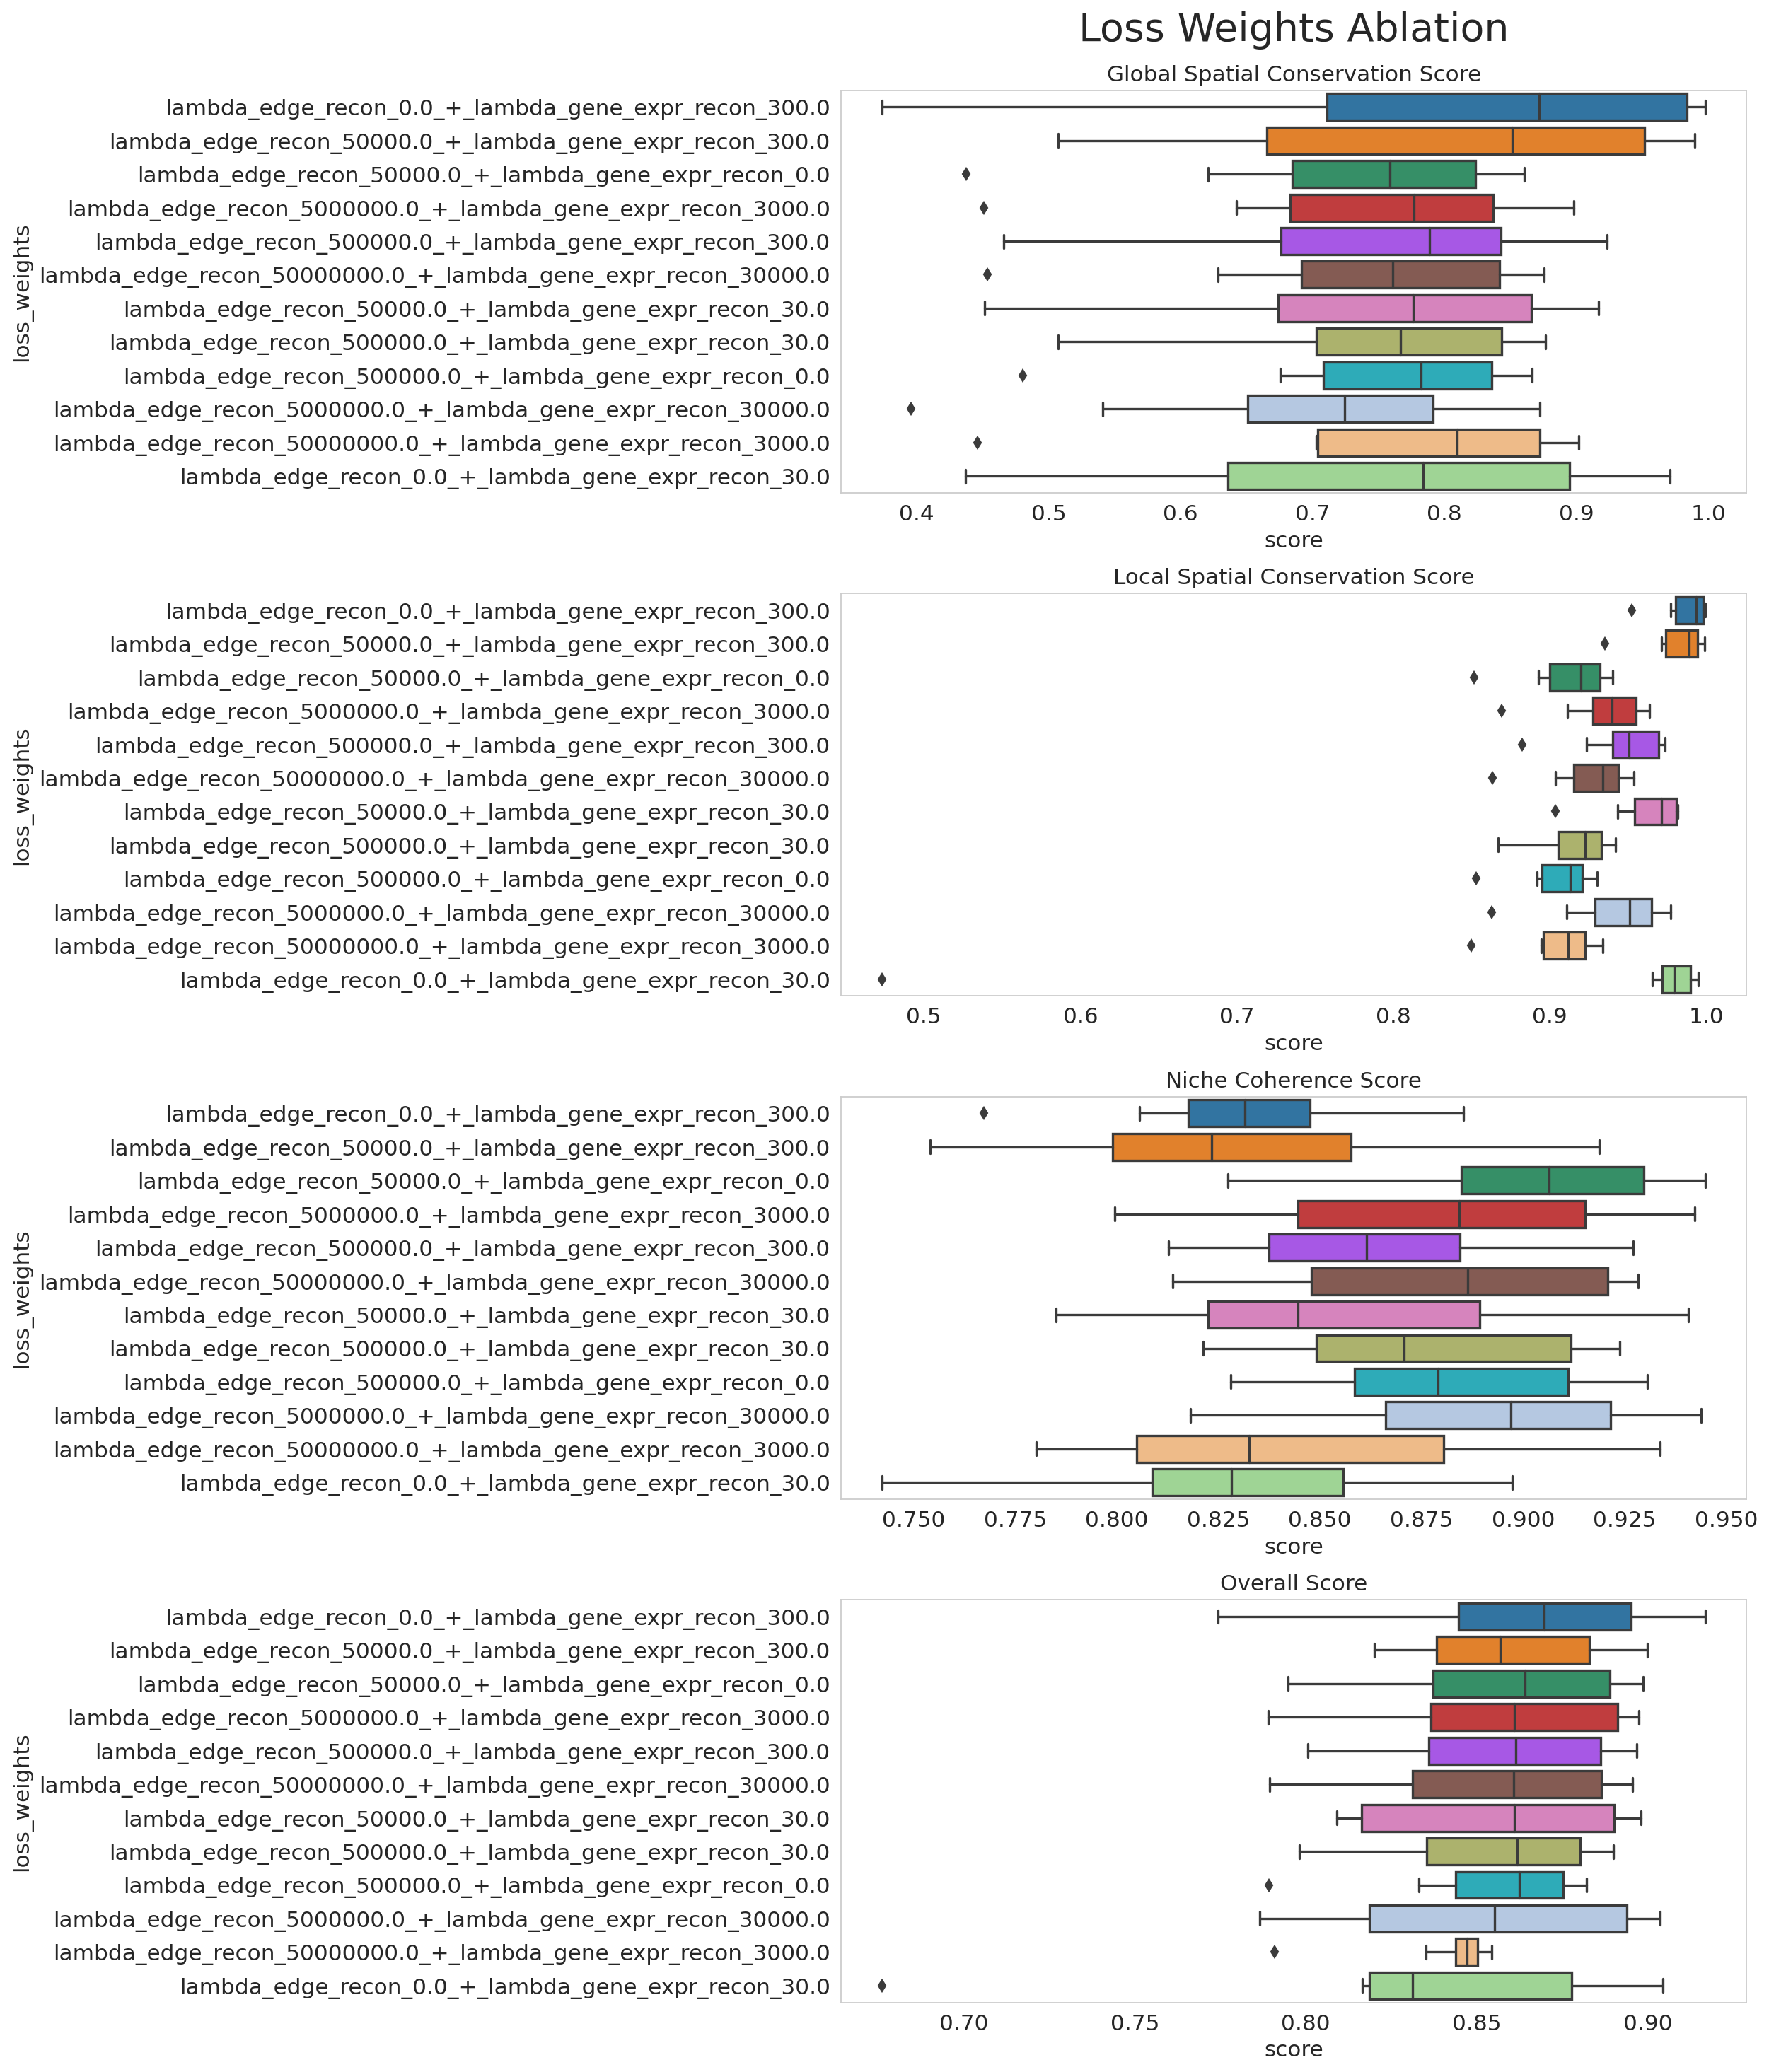

In [169]:
# Plot boxplot with aggregated metrics over all datasets
order = summary_df.groupby(ablation_task).mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"{ablation_task.title().replace('_', ' ')} Ablation",
    df=summary_df,
    group_col=ablation_task,
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"{ablation_task}_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with aggregated metrics over all datasets
order = summary_df.groupby(ablation_task).mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"{ablation_task.title().replace('_', ' ')} Ablation",
    df=summary_df,
    group_col=ablation_task,
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"{ablation_task}_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with all metrics for each dataset individually
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]
    order = dataset_df.groupby(ablation_task).mean("Overall Score").sort_values("Overall Score", ascending=False).index
    plot_metrics_boxplot(
        fig_title=f"{ablation_task.title().replace('_', ' ')} Ablation ({dataset})",
        df=dataset_df,
        group_col=ablation_task,
        metric_cols=metric_cols_single_sample + ["Overall Score"], # category_cols_single_sample + ["Overall Score"]
        metric_col_titles=metric_col_titles_single_sample + ["Overall Score"], # category_col_titles_single_sample + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=ablation_folder_path,
        file_name=f"{ablation_task}_ablation_metrics_boxplot_{dataset}.png")

##### 2.1.1.2 GP Mask

In [ ]:
summary_df.columns

In [ ]:
# Plot boxplot with aggregated metrics over all datasets
order = summary_df.groupby("gp_mask").mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"GP Mask Ablation",
    df=summary_df,
    group_col="gp_mask",
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"gp_mask_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with all metrics for each dataset individually
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]
    order = dataset_df.groupby("gp_mask").mean("Overall Score").sort_values("Overall Score", ascending=False).index
    plot_metrics_boxplot(
        fig_title=f"GP Mask Ablation ({dataset})",
        df=dataset_df,
        group_col="gp_mask",
        metric_cols=metric_cols_single_sample + ["Overall Score"], # category_cols_single_sample + ["Overall Score"]
        metric_col_titles=metric_col_titles_single_sample + ["Overall Score"], # category_col_titles_single_sample + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=ablation_folder_path,
        file_name=f"gp_mask_ablation_metrics_boxplot_{dataset}.png")

##### 2.1.1.3 Number of Neighbors

In [160]:
# Only keep runs with both decoder modules present
filtered_df = summary_df[(summary_df["lambda_edge_recon_"] == 500000.) & (summary_df["lambda_gene_expr_recon_"] == 300.)]

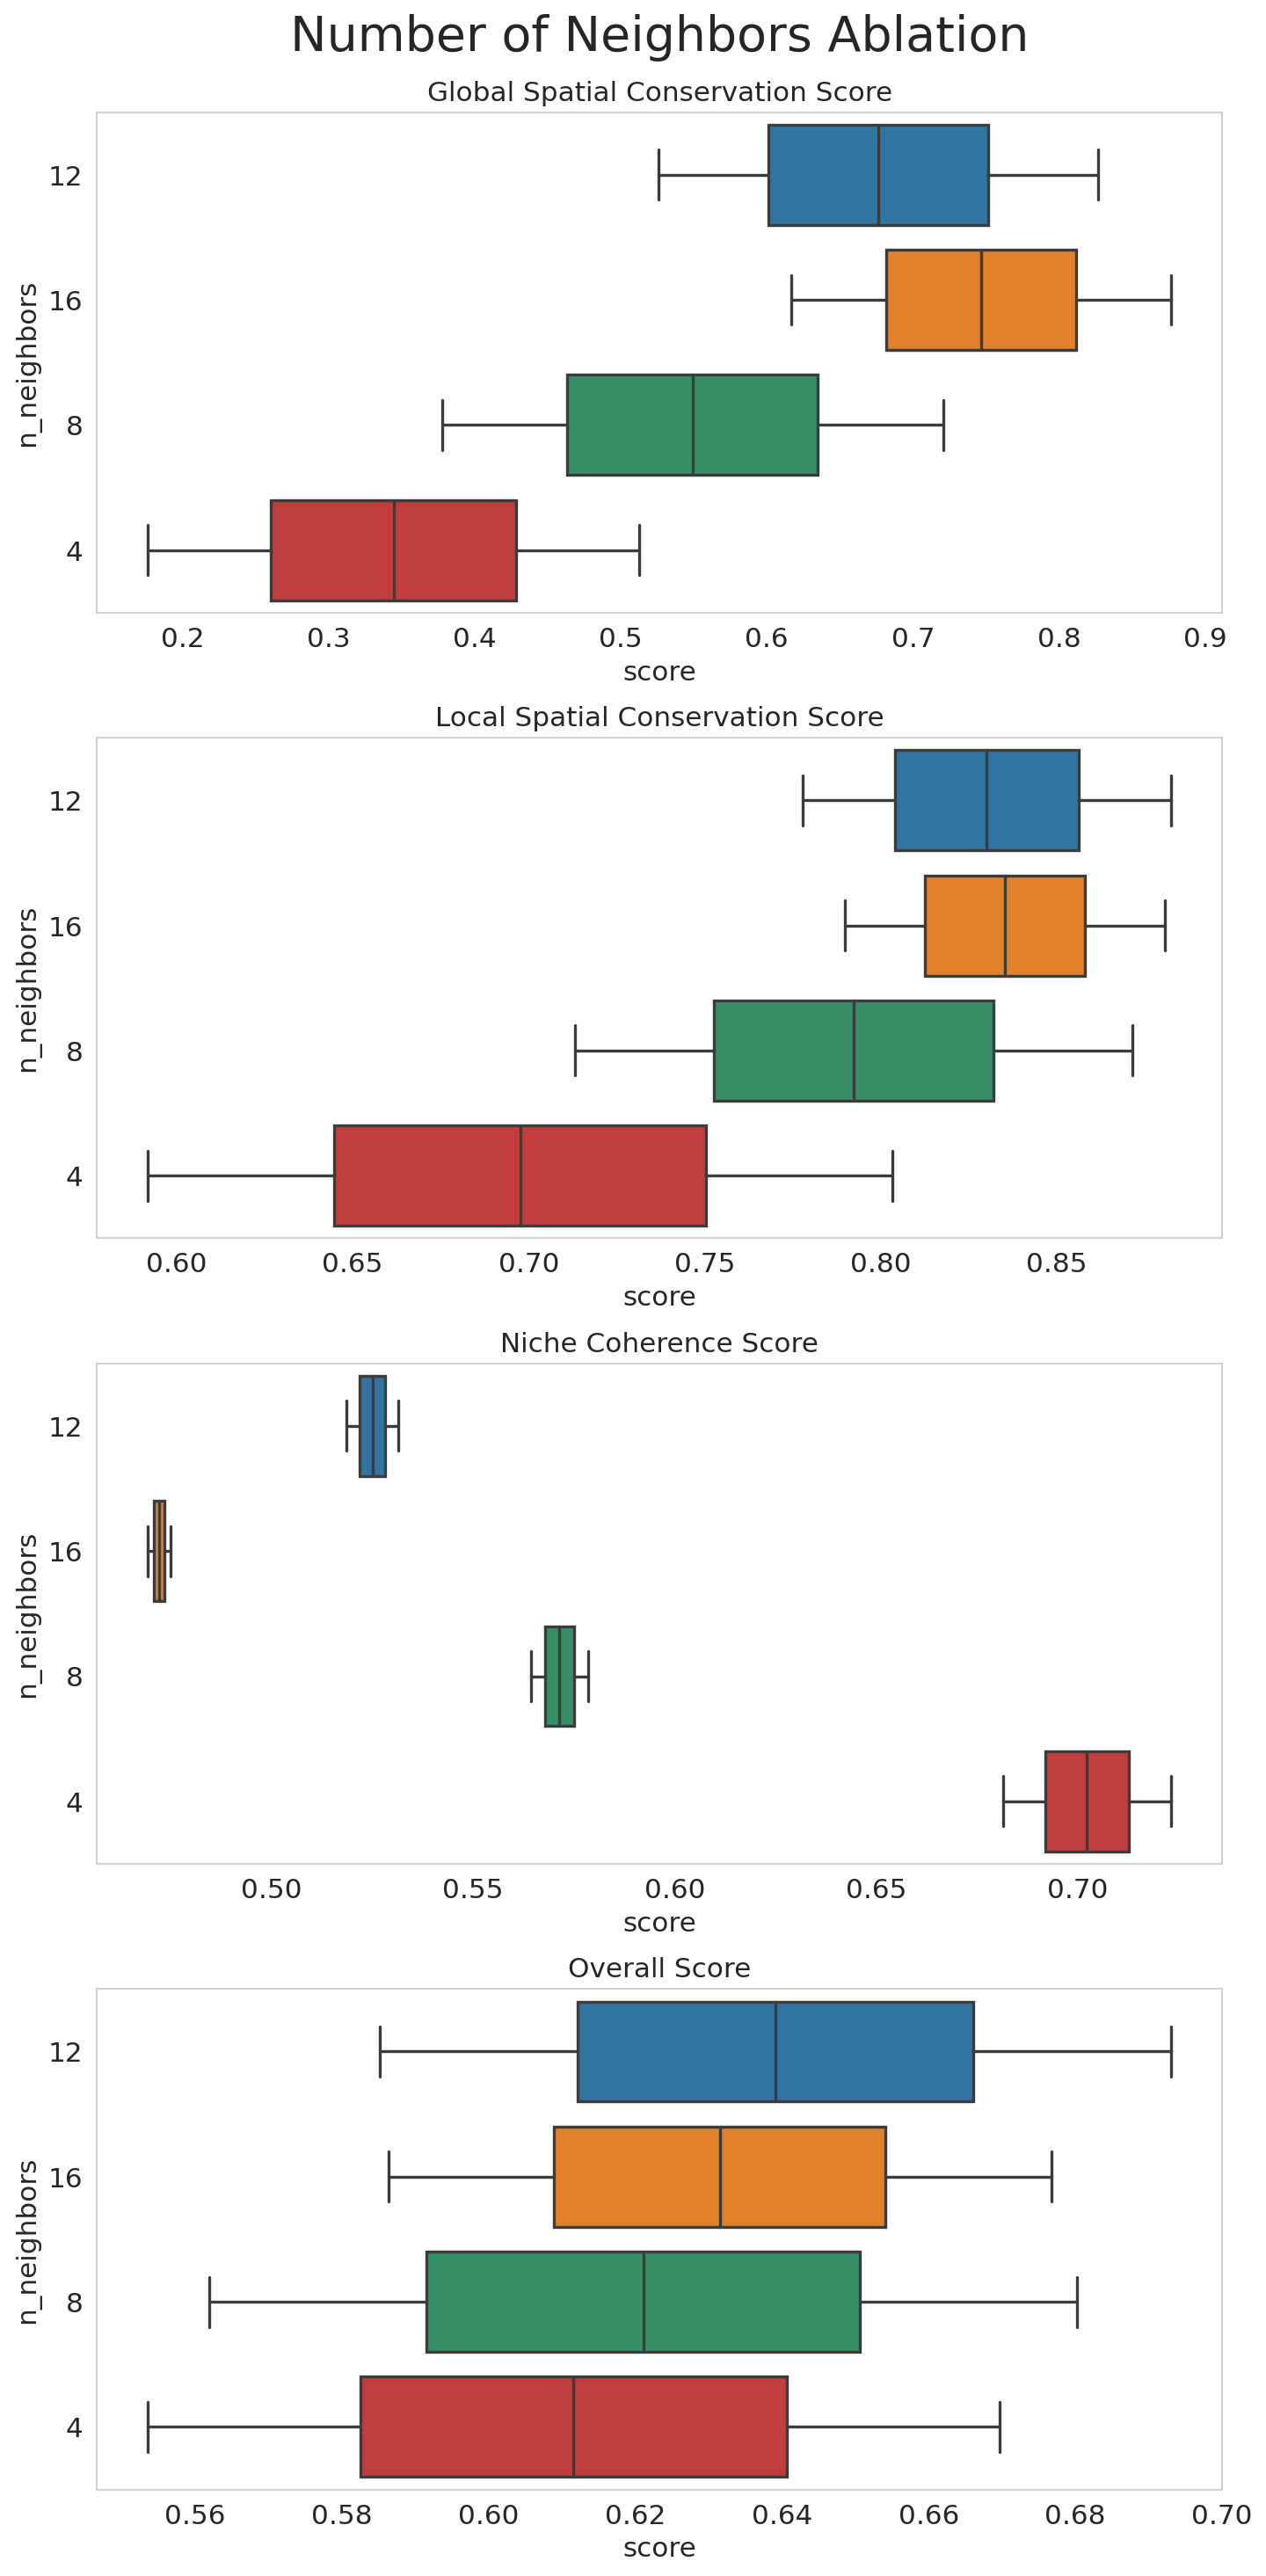

In [161]:
# Plot boxplot with aggregated metrics over all datasets
order = filtered_df.groupby("n_neighbors").mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"Number of Neighbors Ablation",
    df=filtered_df,
    group_col="n_neighbors",
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"n_neighbors_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with all metrics for each dataset individually
for dataset in datasets:
    dataset_df = filtered_df[filtered_df["dataset"] == dataset]
    order = dataset_df.groupby("n_neighbors").mean("Overall Score").sort_values("Overall Score", ascending=False).index
    plot_metrics_boxplot(
        fig_title=f"Number of Neighbors Ablation ({dataset})",
        df=dataset_df,
        group_col="n_neighbors",
        metric_cols=metric_cols_single_sample + ["Overall Score"], # category_cols_single_sample + ["Overall Score"]
        metric_col_titles=metric_col_titles_single_sample + ["Overall Score"], # category_col_titles_single_sample + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=ablation_folder_path,
        file_name=f"n_neighbors_ablation_metrics_boxplot_{dataset}.png")

#### 2.1.2 Plot Metric Tables & Niche Comparison Plots

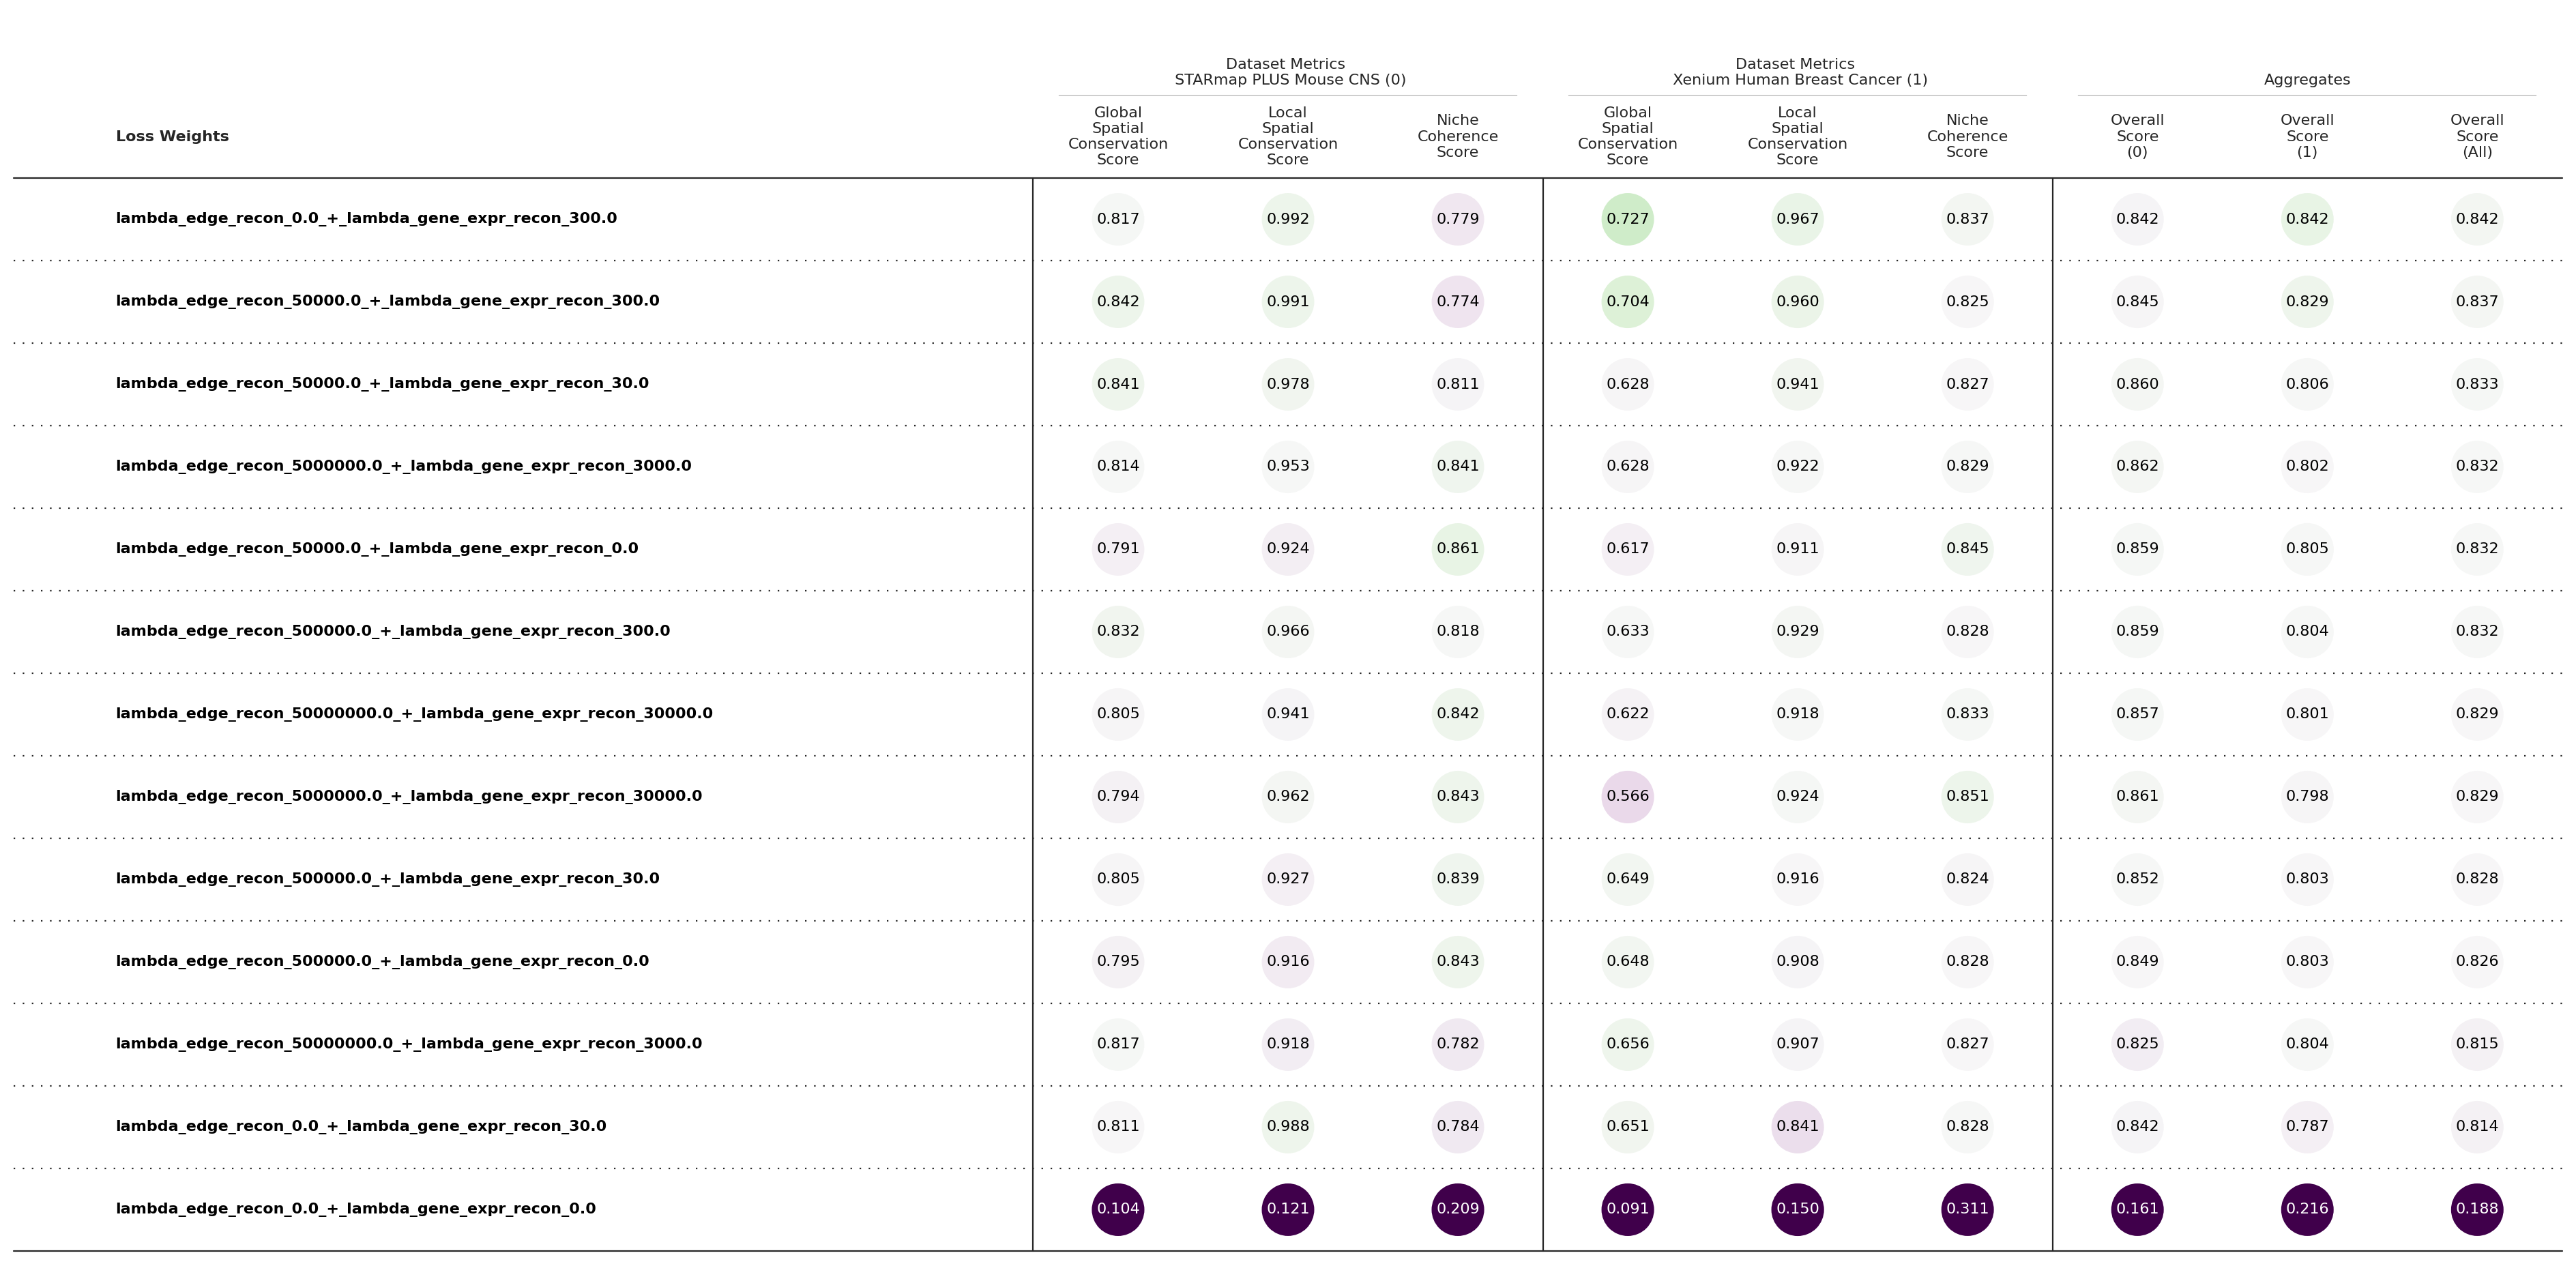

In [128]:
# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "loss_weights"]
aggregate_df = summary_df.groupby(["dataset", "loss_weights"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col=ablation_task,
    ablation_col_width=9,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=30, # 32,
    plot_height=15,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"{ablation_task}_ablation_metrics_table.png")

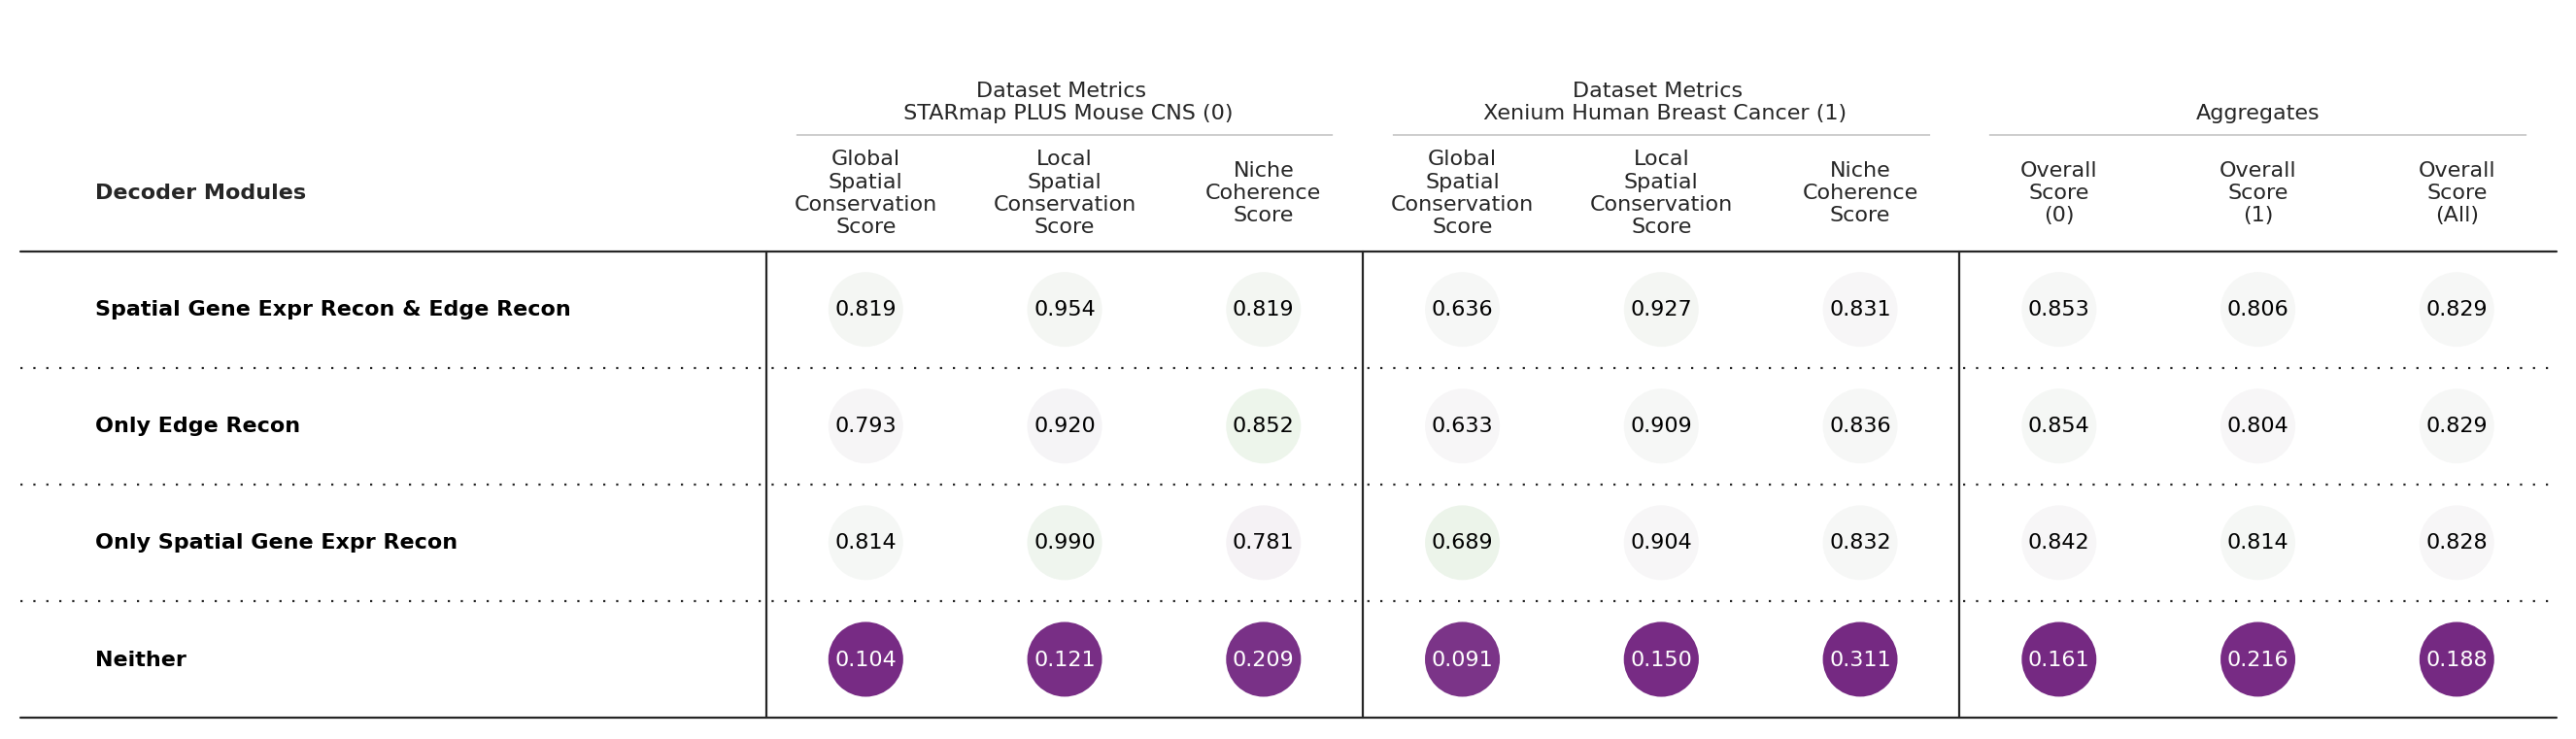

In [129]:
# Plot over aggregated loss weights combinations
summary_df["Decoder Modules"] = summary_df.apply(lambda row: get_loss_weights_combination(row), axis=1)

# Prepare metrics table plot
group_cols = ["dataset", "Decoder Modules"]
aggregate_df = summary_df.groupby(["dataset", "Decoder Modules"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="Decoder Modules",
    ablation_col_width=3.75,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.0, # 0.8,
    plot_width=21, # 32,
    plot_height=6,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"decoder_modules_ablation_aggregated_metrics_table.png")

In [ ]:
# 12 neighbors comparison
dataset = "xenium_human_breast_cancer"

load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]


timestamps = [load_timestamp_edge_recon]

# Plot cell types in latent and physical space
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/{ablation_task}_ablation/{timestamps[0]}/{dataset}_{ablation_task}_ablation.h5ad")

cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="cell_states")

save_fig = True
file_path = f"{ablation_folder_path}/" \
            "cell_types_latent_physical_space.png"

plot_category_in_latent_and_physical_space(
    adata=adata,
    plot_label="Cell Types",
    cat_key="cell_states",
    groups=None,
    sample_key="batch",
    samples=adata.obs["batch"].unique().tolist(),
    cat_colors=cell_type_colors,
    size=(360000 / len(adata)),
    spot_size=30,
    save_fig=save_fig,
    file_path=file_path)
del(adata)
gc.collect()

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 12 neighbors comparison
dataset = "starmap_plus_mouse_cns"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_edge_recon]

# Plot cell types in latent and physical space
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/{ablation_task}_ablation/{timestamps[0]}/{dataset}_{ablation_task}_ablation.h5ad")

cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="Main_molecular_cell_type")

save_fig = True
file_path = f"{ablation_folder_path}/{dataset}_" \
            "cell_types_latent_physical_space.png"

plot_category_in_latent_and_physical_space(
    adata=adata,
    plot_label="Cell Types",
    cat_key="Main_molecular_cell_type",
    groups=None,
    sample_key="batch",
    samples=adata.obs["batch"].unique().tolist(),
    cat_colors=cell_type_colors,
    size=(360000 / len(adata)),
    spot_size=0.1,
    save_fig=save_fig,
    file_path=file_path)
del(adata)
gc.collect()

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 12 neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]


timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# Plot over number of neighbors (only include both decoder modules present)
#filtered_df = summary_df[(summary_df["lambda_edge_recon_"] != 0.) & (summary_df["lambda_gene_expr_recon_"] != 0.)]
#filtered_df = summary_df[(summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon")]
filtered_df = summary_df[(summary_df["lambda_edge_recon_"] == 500000) & (summary_df["lambda_gene_expr_recon_"] == 300)]

# Prepare metrics table plot
group_cols = ["dataset", "n_neighbors"]
aggregate_df = filtered_df.groupby(["dataset", "n_neighbors"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="n_neighbors",
    ablation_col_width=3.75,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1., # 0.8,
    plot_width=21, # 32,
    plot_height=6,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"n_neighbors_ablation_aggregated_metrics_table.png")

In [ ]:
# Neighbors comparison
dataset = "xenium_human_breast_cancer"

load_timestamp_4 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_4]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_8 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_8]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_12 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_12]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_16 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_16]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# neighbors comparison
dataset = "starmap_plus_mouse_cns"

load_timestamp_4 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_4]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_8 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_8]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_12 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_12]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_16 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_16]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_4 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_4]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_8 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_8]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_12 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_12]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

load_timestamp_16 = filtered_df[(filtered_df["dataset"] == dataset) &
                                 (filtered_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_16]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 8 neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 12 neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "loss_weights"]
aggregate_df = summary_df.groupby(["dataset", "loss_weights"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col=ablation_task,
    ablation_col_width=9,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=25, # 32,
    plot_height=15,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"{ablation_task}_ablation_metrics_table.png")

In [ ]:
# Prepare metrics table plot
group_cols = ["dataset", "gp_mask"]
aggregate_df = summary_df.groupby(["dataset", "gp_mask"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="gp_mask",
    ablation_col_width=5,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5,
    plot_width=25,
    plot_height=5,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"gp_mask_ablation_metrics_table.png")

In [ ]:
# Prepare metrics table plot
group_cols = ["dataset", "n_neighbors"]
aggregate_df = summary_df.groupby(["dataset", "n_neighbors"]).mean("overall_score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="n_neighbors",
    ablation_col_width=9,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=25, # 32,
    plot_height=15,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"n_neighbors_ablation_metrics_table.png")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["01072023_101716_27"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["30062023_143855_10"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

### 2.2 Neighbor Sampling

In [80]:
ablation_task = "neighbor_sampling"
task = f"{ablation_task}_ablation"
cross_ablation_task = "loss_weights" # for comparison with no neighbor sampling
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type"]
batch_keys = [None, None, None]
experiment_ids = [9, 10, 11]
sample_key = "batch"

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

ablation_col = "neighbor_sampling"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_target_rna_mse_score"] = run.data.metrics.get("val_target_rna_mse_score", np.nan)
        run_dict["val_source_rna_mse_score"] = run.data.metrics.get("val_source_rna_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_sampled_neighbors"] = run.data.params["n_sampled_neighbors_"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df = summary_df[summary_df["dataset"] == dataset]
    summary_df['val_gene_expr_mse_score'] = summary_df.apply(lambda row: (row['val_target_rna_mse_score'] + row['val_source_rna_mse_score'])/2, axis=1)
    summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index=False)

In [107]:
# Load data and compute overall score
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df["val_gene_expr_mse_score"] = summary_df.apply(lambda row: (row["val_target_rna_mse_score"] + row["val_source_rna_mse_score"])/2, axis=1)
    summary_df["geri"] = summary_df.loc[:, "val_gene_expr_mse_score"].apply(scale_metric)
    summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
    summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [108]:
# Add runs without neighbor sampling from previous ablation
summary_no_sampling_df = pd.DataFrame()
for dataset in datasets:
    dataset_no_sampling_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_{dataset}_metrics.csv")
    dataset_no_sampling_df = dataset_no_sampling_df[(dataset_no_sampling_df["lambda_edge_recon_"] == 500000.0) & (dataset_no_sampling_df["lambda_gene_expr_recon_"] == 300.0)]
    summary_no_sampling_df = pd.concat([summary_no_sampling_df, dataset_no_sampling_df], ignore_index=True)
    summary_no_sampling_df["val_gene_expr_mse_score"] = summary_no_sampling_df.apply(lambda row: (row["val_target_rna_mse_score"] + row["val_source_rna_mse_score"])/2, axis=1)
    summary_no_sampling_df["geri"] = summary_no_sampling_df.loc[:, "val_gene_expr_mse_score"].apply(scale_metric)
    summary_no_sampling_df["n_sampled_neighbors"] = "-1"
    summary_no_sampling_df["n_neighbors"] = summary_no_sampling_df["n_neighbors"].astype(str)
    summary_no_sampling_df["n_sampled_neighbors"] = summary_no_sampling_df["n_sampled_neighbors"].astype(str)

summary_df = pd.concat([summary_df, summary_no_sampling_df], ignore_index=True)

In [109]:
# Apply min-max scaling to metric columns
for i in range(len(metric_cols_single_sample)):
    min_val = summary_df[metric_cols_single_sample[i]].min()
    max_val = summary_df[metric_cols_single_sample[i]].max()
    summary_df[metric_cols_single_sample[i] + "_scaled"] = ((
        summary_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))    

summary_df[category_cols_single_sample[0]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[:2]]], weights=metric_col_weights_single_sample[:2], axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[2:4]]], weights=metric_col_weights_single_sample[2:4], axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[4:6]]], weights=metric_col_weights_single_sample[4:6], axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)

In [110]:
summary_df["n_neighbors"].value_counts()

16    8
8     8
12    8
4     8
Name: n_neighbors, dtype: int64

In [111]:
summary_df["n_sampled_neighbors"].value_counts()

8     8
4     8
2     8
-1    8
Name: n_sampled_neighbors, dtype: int64

#### 2.1.2 Plot Metric Tables & Niche Comparison Plots

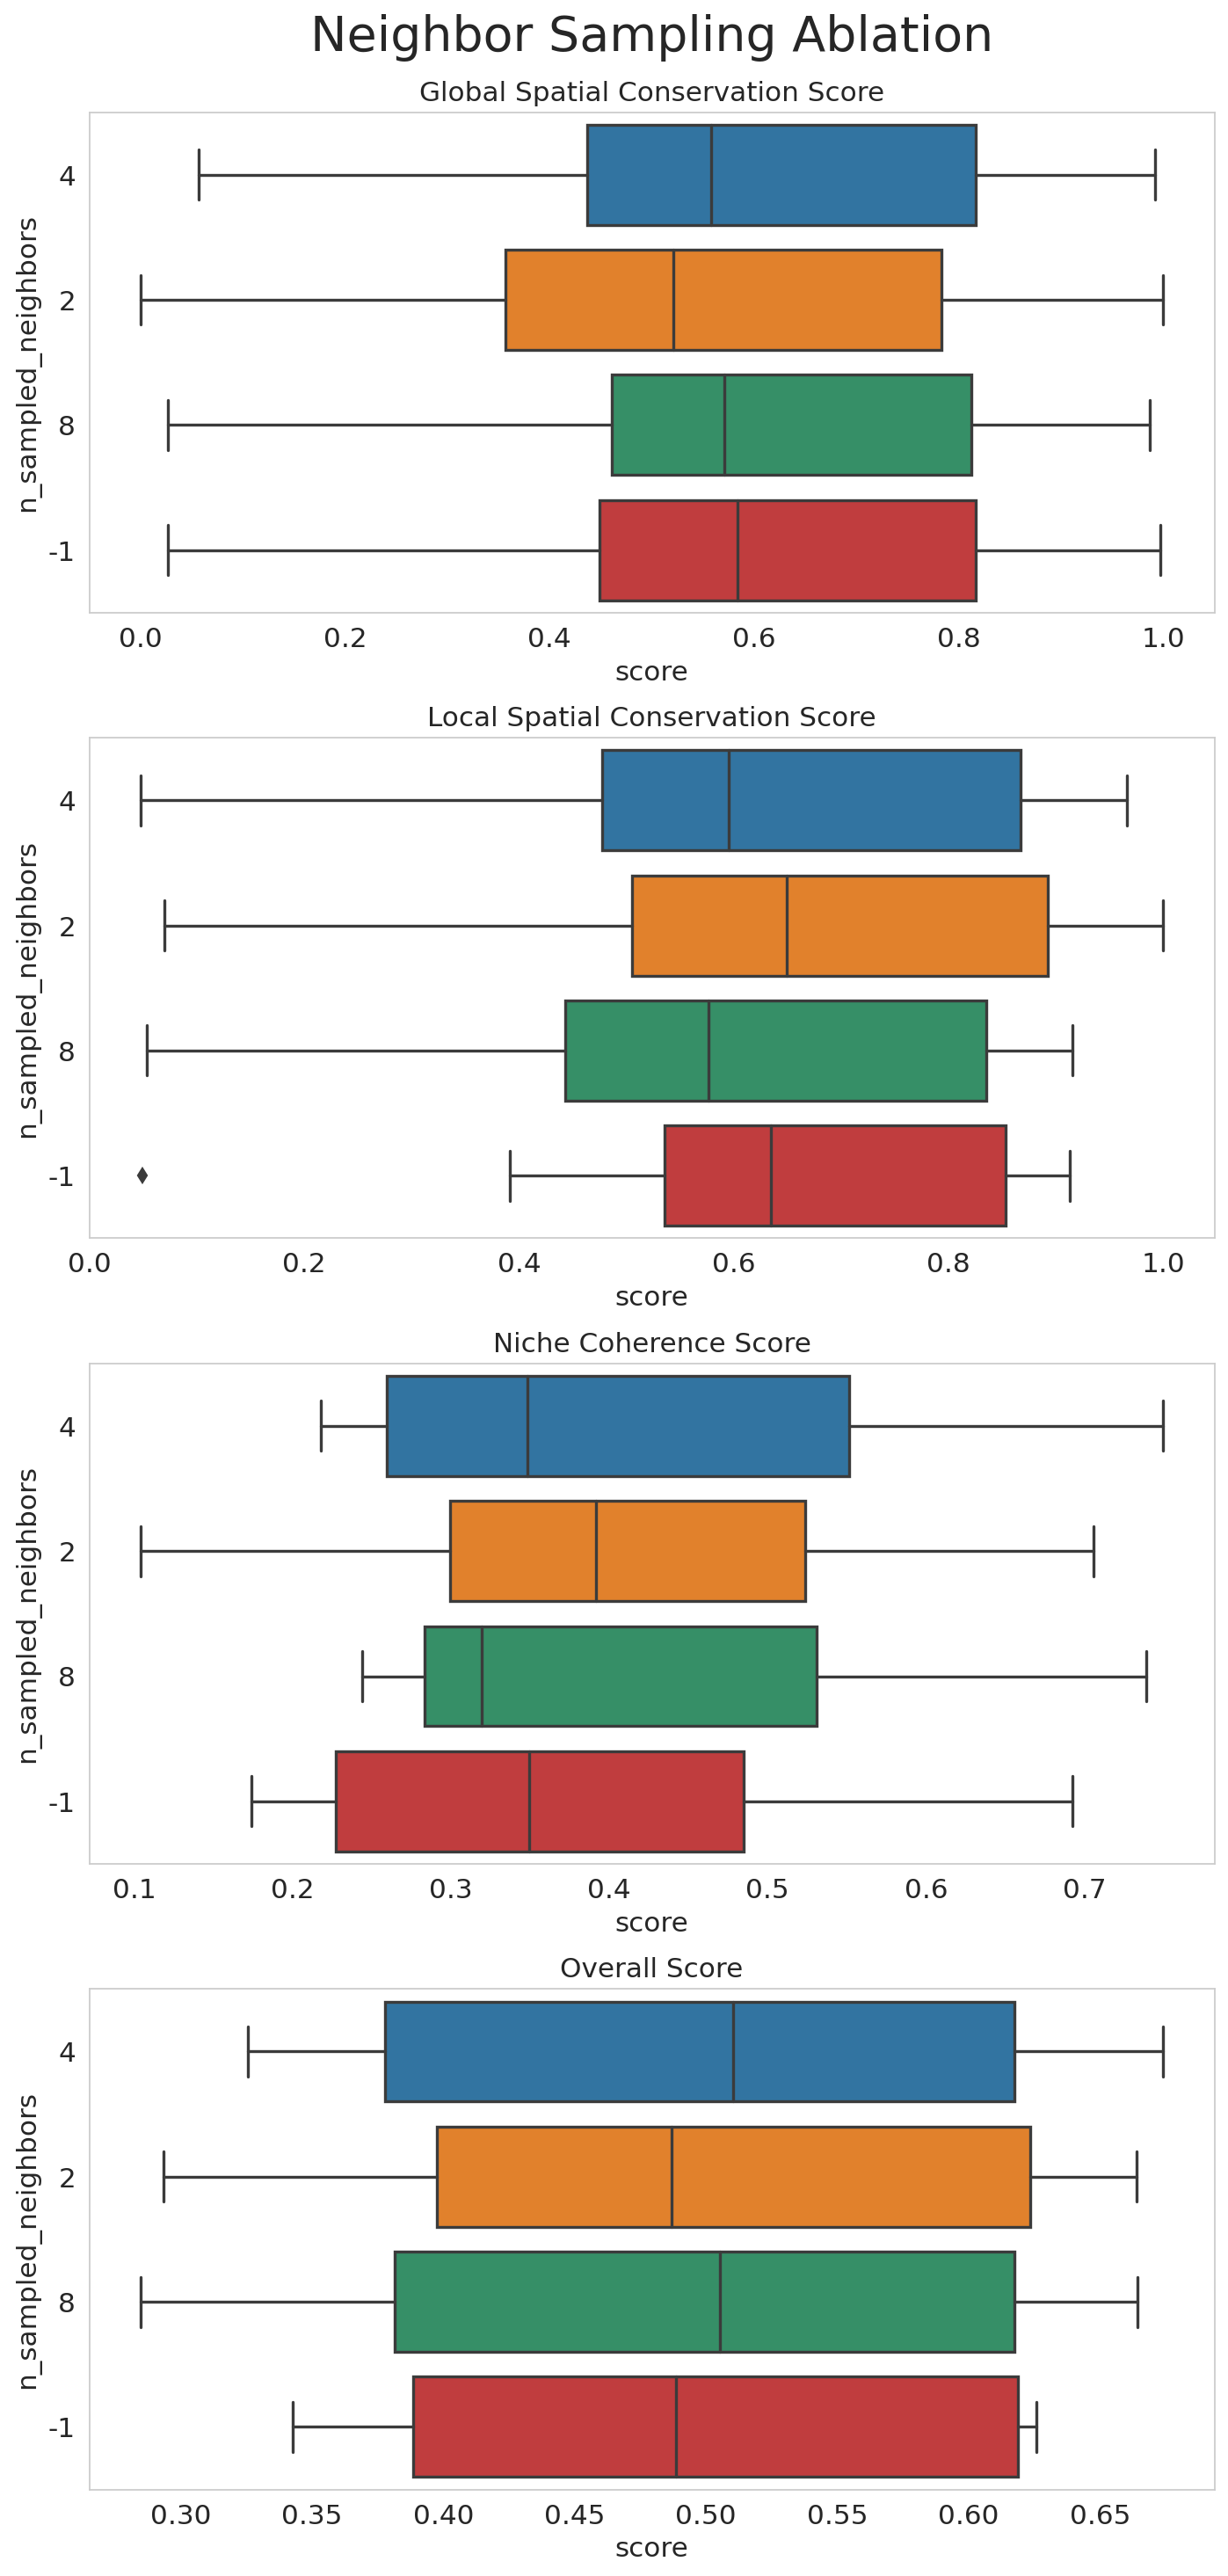

In [112]:
# Plot boxplot with aggregated metrics over all datasets
order = summary_df.groupby("n_sampled_neighbors").mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"{ablation_task.title().replace('_', ' ')} Ablation",
    df=summary_df,
    group_col="n_sampled_neighbors",
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_cols_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"{ablation_task}_ablation_metrics_boxplot.png")

In [ ]:
# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "n_sampled_neighbors"]
aggregate_df = summary_df.groupby(["dataset", "n_sampled_neighbors"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="n_sampled_neighbors",
    ablation_col_width=3,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=20, # 32,
    plot_height=6,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"{ablation_task}_ablation_metrics_table.png")

In [ ]:
dataset = "xenium_human_breast_cancer"

load_timestamp_2 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "2")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_4 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_8 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_no_sampling = summary_df[(summary_df["dataset"] == dataset) &
                                        (summary_df["n_neighbors"] == "12") &
                                        (summary_df["n_sampled_neighbors"] == "-1")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_2]

# Plot cell types in latent and physical space
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/{ablation_task}_ablation/{timestamps[0]}/{dataset}_{ablation_task}_ablation.h5ad")

cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="cell_states")

save_fig = True
file_path = f"{ablation_folder_path}/" \
            "cell_types_latent_physical_space.png"

plot_category_in_latent_and_physical_space(
    adata=adata,
    plot_label="Cell Types",
    cat_key="cell_states",
    groups=None,
    sample_key="batch",
    samples=adata.obs["samples"].unique().tolist(),
    cat_colors=cell_type_colors,
    size=(360000 / len(adata)),
    spot_size=30,
    save_fig=save_fig,
    file_path=file_path)
del(adata)
gc.collect()

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_4]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_8]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_no_sampling]

visualize_niches(artifact_folder_path,
                 dataset,
                 task.replace(ablation_task, cross_ablation_task),
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
dataset = "starmap_plus_mouse_cns"

load_timestamp_2 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "2")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_4 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_8 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_no_sampling = summary_df[(summary_df["dataset"] == dataset) &
                                        (summary_df["n_neighbors"] == "12") &
                                        (summary_df["n_sampled_neighbors"] == "-1")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_2]

# Plot cell types in latent and physical space
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/{ablation_task}_ablation/{timestamps[0]}/{dataset}_{ablation_task}_ablation.h5ad")

cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="Main_molecular_cell_type")

save_fig = True
file_path = f"{ablation_folder_path}/{dataset}_" \
            "cell_types_latent_physical_space.png"

plot_category_in_latent_and_physical_space(
    adata=adata,
    plot_label="Cell Types",
    cat_key="Main_molecular_cell_type",
    groups=None,
    sample_key="batch",
    samples=adata.obs["batch"].unique().tolist(),
    cat_colors=cell_type_colors,
    size=(360000 / len(adata)),
    spot_size=0.1,
    save_fig=save_fig,
    file_path=file_path)
del(adata)
gc.collect()

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_4]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_8]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_no_sampling]

visualize_niches(artifact_folder_path,
                 dataset,
                 task.replace(ablation_task, cross_ablation_task),
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_2 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "2")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_4 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_8 = summary_df[(summary_df["dataset"] == dataset) &
                              (summary_df["n_neighbors"] == "12") &
                              (summary_df["n_sampled_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_no_sampling = summary_df[(summary_df["dataset"] == dataset) &
                                        (summary_df["n_neighbors"] == "12") &
                                        (summary_df["n_sampled_neighbors"] == "-1")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_2]

# Plot cell types in latent and physical space
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/{ablation_task}_ablation/{timestamps[0]}/{dataset}_{ablation_task}_ablation.h5ad")

cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="cell_type")

save_fig = True
file_path = f"{ablation_folder_path}/{dataset}_" \
            "cell_types_latent_physical_space.png"

plot_category_in_latent_and_physical_space(
    adata=adata,
    plot_label="Cell Types",
    cat_key="cell_type",
    groups=None,
    sample_key="batch",
    samples=adata.obs["batch"].unique().tolist(),
    cat_colors=cell_type_colors,
    size=(360000 / len(adata)),
    spot_size=30,
    save_fig=save_fig,
    file_path=file_path)
del(adata)
gc.collect()

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_4]


visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_8]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_no_sampling]

visualize_niches(artifact_folder_path,
                 dataset,
                 task.replace(ablation_task, cross_ablation_task),
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.1,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"{ablation_task}_ablation_{dataset}_niche_comparison")
gc.collect()

### 2.3 Encoder Architecture

In [ ]:
ablation_task = "encoder_architecture"
cross_ablation_task = "loss_weights" # for comparison with no neighbor sampling
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type"]
batch_keys = [None]
experiment_ids = [7, 6]
sample_key = "batch"

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

ablation_col = "encoder_architecture"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_target_rna_mse_score"] = run.data.metrics.get("val_target_rna_mse_score", np.nan)
        run_dict["val_source_rna_mse_score"] = run.data.metrics.get("val_source_rna_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_layers_encoder"] = run.data.params["n_layers_encoder_"]
        run_dict["n_fc_layers_encoder"] = run.data.params.get("n_fc_layers_encoder_", "1") # old API did not track this
        run_dict["conv_layer_encoder"] = run.data.params["conv_layer_encoder_"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index=False)

In [ ]:
summary_df["n_neighbors"].value_counts()

In [ ]:
summary_df["conv_layer_encoder"].value_counts()

In [ ]:
summary_df["n_fc_layers_encoder"].value_counts()

In [ ]:
summary_df["n_layers_encoder"].value_counts()

In [ ]:
# Split into multiple files for each dataset for parallel metrics computation
for dataset in datasets:
    j = 0
    for i in np.arange(4, 36, 4):
        dataset_df = summary_df[summary_df["dataset"] == dataset]
        temp_df = dataset_df[j:i]
        temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv", index=False)
        j = i

In [ ]:
datasets = ["xenium_human_breast_cancer"]

In [ ]:
# Aggregate into one metrics files
dataset_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for i in np.arange(4, 36, 4):
        iteration_df = pd.read_csv(f"../../artifacts/{ablation_task}_ablation/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv")
        dataset_df = pd.concat([dataset_df, iteration_df], ignore_index=True)
        if "Unnamed: 0" in dataset_df.columns:
            dataset_df.drop("Unnamed: 0", axis=1, inplace=True)
        dataset_df = dataset_df.fillna(0.0)
        dataset_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv", index=False)

In [ ]:
def get_encoder_architecture(row):  
    return f"FC_{row['n_fc_layers_encoder']}_+_MP_{row['n_layers_encoder']}_+_{row['conv_layer_encoder'].upper()}"

In [ ]:
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]

In [ ]:
    
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))   
    
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
    summary_df["val_gene_expr_mse_score"] = summary_df.apply(lambda row: (row["val_target_rna_mse_score"] + row["val_source_rna_mse_score"])/2, axis=1)
    summary_df["geri"] = summary_df.loc[:, "val_gene_expr_mse_score"].apply(scale_metric)
    summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
    
    summary_df = summary_df[summary_df["loss_weights"] != "lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0"]
     
    
    summary_df[category_cols_single_sample[0]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[:2]]], weights=metric_col_weights_single_sample[:2], axis=1)
    summary_df[category_cols_single_sample[1]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[2:4]]], weights=metric_col_weights_single_sample[2:4], axis=1)
    summary_df[category_cols_single_sample[2]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[4:6]]], weights=metric_col_weights_single_sample[4:6], axis=1)
    #summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
    summary_df["Overall Score"] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample]], weights=[0.125, 0.125, 0.125, 0.125, 0.25, 0.25] ,axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [170]:
# Load data and compute overall score
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))   
    
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df["val_gene_expr_mse_score"] = summary_df.apply(lambda row: (row["val_target_rna_mse_score"] + row["val_source_rna_mse_score"])/2, axis=1)
    summary_df["geri"] = summary_df.loc[:, "val_gene_expr_mse_score"].apply(scale_metric)
    summary_df[category_cols_single_sample[0]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[:2]]], weights=metric_col_weights_single_sample[:2], axis=1)
    summary_df[category_cols_single_sample[1]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[2:4]]], weights=metric_col_weights_single_sample[2:4], axis=1)
    summary_df[category_cols_single_sample[2]] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample[4:6]]], weights=metric_col_weights_single_sample[4:6], axis=1)
    #summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
    summary_df["Overall Score"] = np.average(summary_df[[metric + "_scaled" for metric in metric_cols_single_sample]], weights=[0.125, 0.125, 0.125, 0.125, 0.25, 0.25] ,axis=1)

summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
summary_df["Encoder Architecture"] = summary_df.apply(lambda row: get_encoder_architecture(row), axis=1)

NameError: name 'get_encoder_architecture' is not defined

In [98]:
summary_df = summary_df[1:]

#### 2.3.2 Plot Metric Tables & Niche Comparison Plots

In [162]:
# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "Encoder Architecture"]
aggregate_df = summary_df.groupby(["dataset", "Encoder Architecture"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="Encoder Architecture",
    ablation_col_width=3,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=20, # 32,
    plot_height=10,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"{ablation_task}_ablation_metrics_table.png")

KeyError: 'Encoder Architecture'

#### 2.1.2 Categorical Covariates Contrastive Loss

In [ ]:
summary_df

### 2.5 Spatial Neighborhood Graph

In [ ]:
visualize_niches(artifact_folder_path=artifact_folder_path,
                 dataset=dataset,
                 task=ablation_task + "_ablation",
                 timestamps=timestamps,
                 sample_key="batch",
                 latent_key=latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30.)

### 2.5 Gene Program Mask

In [ ]:
"""
# Log additional mlflow param
run_ids = []
runs_info = mlflow.list_run_infos(3)
for run_info in runs_info:
    run = mlflow.get_run(run_info.run_uuid)
    if "add_fc_gps_instead_of_gp_dict_gps" not in run.data.params:
        run_ids.append(run_info.run_uuid)
        
for run_id in run_ids:
    with mlflow.start_run(run_id=run_id) as run:
        mlflow.log_param("add_fc_gps_instead_of_gp_dict_gps", True)
"""

In [ ]:
# tmp
summary_df = summary_df[["dataset", "timestamp", "val_target_rna_mse_score", "val_source_rna_mse_score"]]
for i in np.arange(4, 36, 4):
    iteration_df = pd.read_csv(f"../../artifacts/{ablation_task}_ablation/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv", index_col=0)
    iteration_df = iteration_df.merge(summary_df, on=["dataset", "timestamp"], how="left")
    if "Unnamed: 0" in iteration_df.columns:
        iteration_df.drop("Unnamed: 0", axis=1, inplace=True)
    iteration_df.drop("val_gene_expr_mse_score", axis=1, inplace=True)
    iteration_df = iteration_df[['dataset', 'timestamp', 'val_auroc_score', 'val_target_rna_mse_score', 'val_source_rna_mse_score', 'n_neighbors',
       'n_layers_encoder', 'n_fc_layers_encoder', 'conv_layer_encoder', 'gcs',
       'mlami', 'cas', 'clisis', 'nasw', 'cnmi', 'cari', 'casw', 'clisi']]
    iteration_df.to_csv(f"../../artifacts/{ablation_task}_ablation/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv", index=False)

In [ ]:
# Load data
summary_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(20, 240, 20):
        iteration_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv")
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_metrics.csv", index=False)

In [ ]:
result_df[[
        'dataset', 'timestamp', 'loss_weights', 'gp_mask', 'n_neighbors', 'val_auroc_score', 'val_gene_expr_mse_score',
        'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'nichenet_keep_target_genes_ratio', 'add_fc_gps_instead_of_gp_dict_gps',
        'gcs', 'mlami', 'cas', 'clisis', 'geri', 'cari', 'cnmi', 'casw', 'clisi', 'nasw', 'gcs_old', 'mlami_old', 'cas_old']].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")

In [ ]:
# Unroll points df and compute means over group columns and score type
unrolled_points_df = pd.melt(points_df, 
   id_vars=group_cols,
   value_vars=metric_score_cols,
   var_name="score_type", 
   value_name="score")

# Compute metric means over all runs
mean_points_df = unrolled_points_df.groupby(group_cols + ["score_type"]).mean()
mean_points_df.reset_index(inplace=True)

In [ ]:
mean_points_df

In [ ]:
plot_ablation_points(df=mean_points_df,
                     ablation_col=ablation_col,
                     ablation_col_width=7,
                     group_col=dataset_col,
                     metric_cols=metric_score_cols,
                     show=True,
                     save_dir=None,
                     save_name="ablation_results.svg")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            task=ablation_task + "_ablation",
                            timestamps=timestamps,
                            dataset="xenium_human_breast_cancer",
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=30.,
                            save_fig=False)

In [ ]:
# tmp
dataset = "starmap_plus_mouse_cns"
dataset_df = summary_df[summary_df["dataset"] == dataset]

column_mapping = {
    'gcs': 'gcs_old',
    'mlami': 'mlami_old',
    'cas': 'cas_old'
}

# Use the rename method with the column_mapping dictionary
dataset_df.rename(columns=column_mapping, inplace=True)

# Split into multiple files for each dataset for parallel metrics computation
j = 200
for i in np.arange(204, 212, 4):
    temp_df = dataset_df[j:i]
    temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
    j = i

In [ ]:
# tmp
datasets = ["vizgen_merfish_human_ovarian_cancer"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 1068, 1072, 1076, 1084, 1064, 1080, 1060, 1004, 1008, 1012, 1044, 1040, 1056, 1020, 1032, 1048, 1036, 1024, 1028, 1052, 2026, 2028, 2006, 2012, 2024, 2010, 2014, 2022, 2020, 2016, 2018, 1016, 2008]:
        iteration_df = pd.read_csv(f"../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_{datasets[0]}_{i}_metrics.csv", index_col=0)
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

summary_df["geri"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)
test_df = summary_df[["dataset", "timestamp"] + metric_cols_single_sample]

df = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer.csv")

df_combined = df.merge(test_df, on=["dataset", "timestamp"], how="left")
df_combined.drop("Unnamed: 0", axis=1, inplace=True)

# Drop rows with all NaN values
df_filtered = df_combined[df_combined["gcs"].isnull()]

#j = 0
#for i in np.arange(4, 85, 4):
#    temp_df = df_filtered[["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "lambda_edge_recon_", "lambda_gene_expr_recon_", "n_neighbors", "nichenet_keep_target_genes_ratio", "add_fc_gps_instead_of_gp_dict_gps"]][j:i]
#    temp_df.to_csv(f"../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer_{i+1000}.csv")
#    j = i

In [ ]:
adata = sc.read_h5ad("../datasets/srt_data/gold/vizgen_merfish_human_ovarian_cancer_batch2.h5ad")

In [ ]:
df2 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer_extra10_metrics.csv")
df2["add_fc_gps_instead_of_gp_dict_gps"] = False
df2["loss_weights"] = df2.apply(lambda row: get_loss_weights(row), axis=1)
df2["gp_mask"] = df2.apply(lambda row: get_gp_mask(row), axis=1)
df2["n_neighbors"] = df2["n_neighbors"].astype(str)
df2["geri"] = df2.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)


summary_df = pd.concat([df, df2], ignore_index=True)


summary_df = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics.csv")

summary_df = summary_df[['dataset', 'timestamp', 'loss_weights', 'gp_mask', 'n_neighbors', 'val_auroc_score', 'val_gene_expr_mse_score',
       'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'nichenet_keep_target_genes_ratio', 'add_fc_gps_instead_of_gp_dict_gps',
       'gcs', 'mlami', 'cas', 'clisis', 'geri', 'cari', 'cnmi', 'casw', 'clisi', 'nasw']]


summary_df.to_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics.csv", index=False)

In [ ]:
summary_df[0:3]["timestamp"].tolist()

In [ ]:
summary_df[["dataset", "timestamp", "n_neighbors", "gcs_old", "mlami_old", "cas_old", "clisis", "cari", "cnmi", "casw", "clisi", "nasw"]]

In [ ]:
summary_df["n_neighbors"].astype(int)

In [ ]:
mtc = compute_metrics(artifact_folder_path=artifact_folder_path,
                dataset="starmap_plus_mouse_cns",
                nums_neighbors=summary_df[0:3]["n_neighbors"].astype(int).tolist(),
                task="loss_weights_ablation",
                timestamps=summary_df[0:3]["timestamp"].tolist(),
                cell_type_key="Main_molecular_cell_type",
                batch_key=None,
                spatial_key=spatial_key,
                latent_key=latent_key,
                n_jobs=1,
                metrics=[    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # niche identification
                        ],
                file_name="temp.csv")

In [ ]:
summary_df[0:3][["dataset", "n_neighbors", "timestamp", "gcs_old", "mlami_old", "cas_old"]]

In [ ]:
summary_df.rename({"gcs": "gcs_old"}, axis=1, inplace=True)

In [ ]:
summary_df

In [ ]:
summary_df.rename({"mlami": "mlami_old"}, axis=1, inplace=True)

In [ ]:
summary_df.rename({"cas": "cas_old"}, axis=1, inplace=True)

In [ ]:
summary_df = summary_df[summary_df["dataset"] == "starmap_plus_mouse_cns"]

In [ ]:
2+3

In [ ]:
summary_df.set_index(['dataset', 'timestamp'], inplace=True)
mtc.set_index(['dataset', 'timestamp'], inplace=True)

# Fill NaN values in df1 with non-NaN values from df2
result_df = summary_df.combine_first(mtc)

# Reset the index to bring 'key1' and 'key2' columns back as regular columns
result_df.reset_index(inplace=True)

In [ ]:
df = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_4.csv", index_col=0)
df2 = pd.read_csv("../../artifacts/loss_weights_ablation/temp_metrics_temp11.csv", index_col=0)
df3 = pd.read_csv("../../artifacts/loss_weights_ablation/temp_metrics_temp12.csv", index_col=0)
df4 = pd.read_csv("../../artifacts/loss_weights_ablation/temp_metrics_temp13.csv", index_col=0)
df_extra = pd.concat([df2, df3, df4], axis=0)
df = df.merge(df_extra, on=["dataset", "timestamp"])
df.to_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_4_metrics.csv")